# Лабораторная работа № 4. Латентное размещение Дирихле

In [1]:
import numpy as np
import pandas as pd

import joblib
import matplotlib.pyplot as plt

import scipy.sparse

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [2]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [3]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Rosa Moline is the neglected wife of a small-town Wisconsin doctor. She grows bored and becomes infatuated with a visiting Chicago businessman. She extorts money from her husband's patients and uses the cash to flee to Chicago, but the businessman does not welcome her. She returns home and becomes pregnant by her husband. The businessman has a change of heart and follows her to Wisconsin. He wants her back, but not her baby, so she attempts to abort by throwing herself down a hill, gets peritonitis and dies. 

A traveller named Lockwood (Miles Mander) is caught in the snow and stays at the estate of Wuthering Heights, despite the cold behaviour of his aged host, Heathcliff (Laurence Olivier). Late that night, after being shown into an upstairs room that was once a bridal chamber, Lockwood is awakened by a cold draft and finds the window shutter flapping back and forth. Just as he is about to close it, he feels an icy hand clutching his and sees a woman outside calling, "Heathcliff, let

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [4]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

[nltk_data] Downloading package punkt to /home/anabatsh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anabatsh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [7]:
print(data.sample(1).values[0])

keshu jayasurya is a school an introvert he is working in a photocopy store owned by indrapalan suraj venjaramood keshu is crazy about rose meera nandan a sale girl in the nearby boutique keshu often take photocopy of currency note which look like real but he fear to spend them one day he meet daany mukesh an anglo indian who realizes the competence of keshu in creating fake currency danny force him to continue with his act danny get the information that a popular party in kerala is bringing crore of rupee to kerala from bangalore by road danny make a scene with the help of some rowdy and cleverly replaces the crore real note with fake one they hide the real note in a slum under the supervision of iruttu kalabhavan mani when the political party start spending the money police get the information and an intelligence bureau officer played by anoop menon start investigating in the mean time keshu mom get admitted in the hospital and keshu immediately want to pay in the hospital they go to

Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

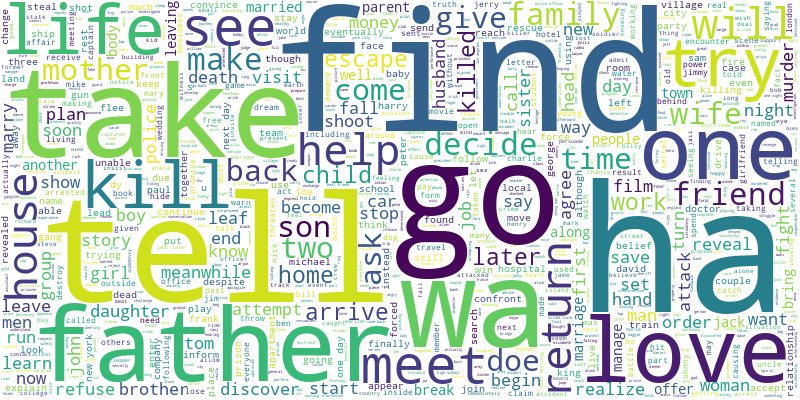

In [8]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anabatsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

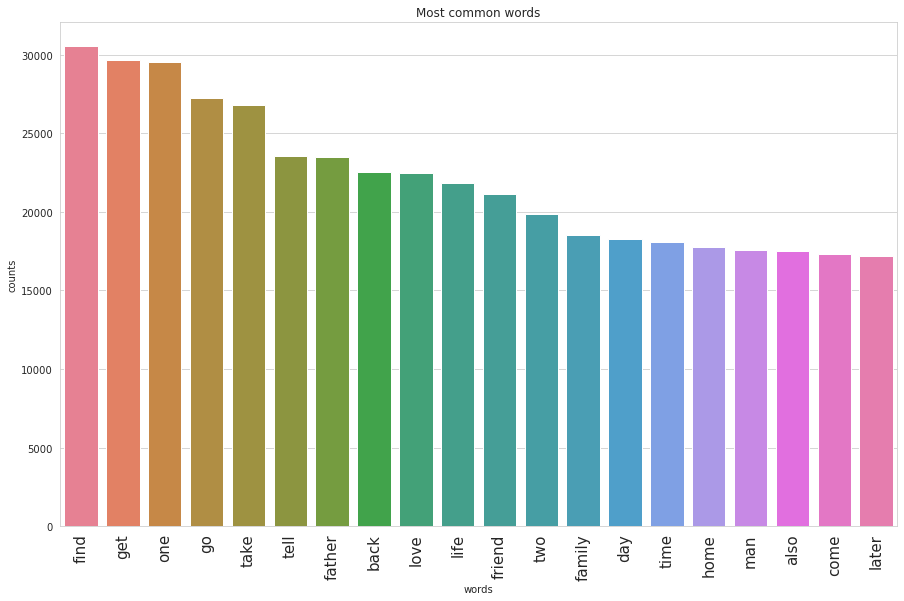

In [13]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

In [16]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [17]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="batch",
    learning_offset=50.0,
    random_state=42,
    n_jobs=-1
)

n_top_words = 20 

lda.fit(count_data)
phi_matrix = lda.components_
        
print_topics(count_vectorizer, phi_matrix, n_top_words)


Topic #0
joe harry find peter father tell take go one back return home get see mother day later come friend time

Topic #1
find one max johnny take kill escape back agent new jack attempt help time two return world however team go

Topic #2
police kill film one take officer find get gang killed also vijay go life murder friend later man death tell

Topic #3
find go get police tell car house one back take money kill two man home jim try friend later see

Topic #4
one ship kill escape john find take two attack men killed order soldier back fight army king return battle force

Topic #5
go one tell new life friend school get find home take time mother day film two back father make love

Topic #6
get raja love father family go find take one brother money life tell friend come meet also son daughter two

Topic #7
love get father family life son come friend one daughter go mother take day village house find marriage also girl

Topic #8
tom jerry take back anna war bill get one men go return 

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

Выделим 20 главных слов на каждую тему

In [18]:
words = count_vectorizer.get_feature_names()
topics = phi_matrix.argsort(1)[:, :-n_top_words-1:-1]

Для каждого слова из мешка определим его встречаемость: частота встреч данного слова во всех документах. Значение принадлежит от 0 до 1.

In [19]:
freq = np.array((count_data > 0).sum(0) / count_data.shape[0])[0]

Посмотрим на частоту встречаемости слов общего употребления в темах.

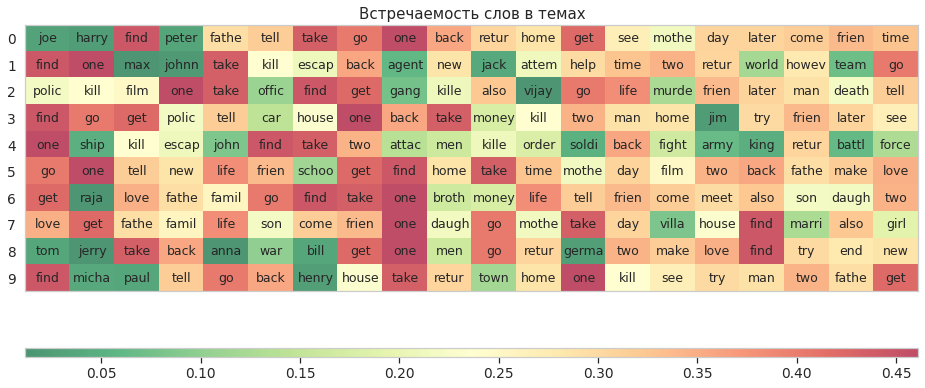

In [26]:
def freq_words(topics):
    plt.subplots(figsize=(16, 7))

    color = freq[topics]

    plt.title('Встречаемость слов в темах')
    plt.imshow(color, alpha=0.7, cmap='RdYlGn_r', aspect='auto')

    plt.xticks([])
    plt.yticks(np.arange(topics.shape[0]))

    for topic_idx, topic in enumerate(topics):
        for i, idx in enumerate(topic):
            plt.text(i, topic_idx, words[idx][:5], ha="center", va="center", fontsize='small')

    plt.colorbar(orientation="horizontal", aspect=100)
    plt.grid()
    plt.show()

freq_words(topics)

Красным обозначены слова общей лексики, попавшие в темы. Например, 'one', 'take', 'find'. Действительно, эти слова общего употребления и не зависят от конкретной темы. В данном случае нет тем, которые оошлись бы без слов общей лексики: в каждой теме есть хотя бы одно 'красное' слово. 

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$
p(W, t \mid \Phi, \pi) = 
p(W \mid t, \Phi) \; p(t \;|\; \pi) = 
\prod\limits_{d=1}^D p(t_d \mid \pi) \prod\limits_{n=1}^{N_d}p(w_{dn} \mid t_d, \Phi) = 
\prod\limits_{d=1}^D \pi_{t_d} \prod\limits_{n=1}^{N_d} \Phi_{t_d, w_{dn}}  = 
\prod\limits_{d=1}^D \prod\limits_{k=1}^{T} [\pi_k \prod\limits_{n=1}^{N_d} \Phi_{k, w_{dn}}]^{[k = t_d]}
$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t \mid W, \Phi, \pi) ) \to \underset{q(t)}{\min}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \mid \Phi, \pi) \to \underset{\Phi, \pi}{\max}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

---
Перепишем немного $p(W, t \mid \Phi, \pi)$

$
\begin{split}
p(W, t \mid \Phi, \pi) = 
p(W \mid t, \Phi) \; p(t \;|\; \pi) &= 
\prod\limits_{d=1}^D p(t_d \mid \pi) \prod\limits_{n=1}^{N_d}p(w_{dn} \mid t_d, \Phi) = \\
&= \prod\limits_{d=1}^D \pi_{t_d} \prod\limits_{n=1}^{N_d} \Phi_{t_d, w_{dn}} = 
\prod\limits_{d=1}^D \prod\limits_{k=1}^{T} [\pi_k \prod\limits_{n=1}^{N_d} \Phi_{k, w_{dn}}]^{[k = t_d]} = \\
&= \prod\limits_{d=1}^D \prod\limits_{k=1}^{T} [\pi_k \prod\limits_{w=1}^{V} \prod\limits_{n=1}^{N_d} \Phi_{k, w}^{[w = w_{dn}]}]^{[k = t_d]} =
\prod\limits_{d=1}^D \prod\limits_{k=1}^{T} [\pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{\sum \limits_{n=1}^{N_d}[w = w_{dn}]}]^{[k = t_d]}
\end{split}
$

Поскольку наблюдать мы будем $X = \{x_{dw}\} \in \mathbb{R}^{D \times V}$ - матрицу числа вхождений каждого слова из словаря в каждый документ - то заменим выражение $\sum \limits_{n=1}^{N_d}[w = w_{dn}]$ на $x_{dw}$. Тогда 

$\fbox{$
p(W, t \mid \Phi, \pi) = 
\prod\limits_{d=1}^D \prod\limits_{k=1}^{T} [\pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}}]^{[k = t_d]}
$}$

---
**Е-шаг:**

Поскольку $t$ - дискретная с.в., то апостериорное распределение $p(t \mid W, \Phi, \pi)$ можно вычислить аналитически на Е-шаге:

$
q(t) = 
p(t \mid W, \Phi, \pi) = 
\prod\limits_{d=1}^D p(t_d \mid W, \Phi, \pi) = 
\prod\limits_{d=1}^D q(t_d)
$

$
q(t_d) = 
p(t_d \mid W, \Phi, \pi) = 
\frac{1}{C_d}p(W, t_d \mid \Phi) \; p(t_d \mid \pi) = 
\frac{1}{C_d}\prod\limits_{k=1}^{T} [\pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}}]^{[k = t_d]}, \quad
C_d$ - нормировочная константа

Значит,
$
q(t_d = k) = 
\frac{1}{C_d}\pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}} = \mu_{dk}, \;\;
$ а $
C_d = \sum\limits_{k=1}^T q(t_d = k) = \sum\limits_{k=1}^T \pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}}
\;\; \Rightarrow \;\;
\fbox{
$
q(t_d = t) = 
\frac{\pi_t \prod\limits_{w=1}^{V} \Phi_{t, w}^{x_{dw}}}
{\sum\limits_{k=1}^T \pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}}} = \mu_{dt}
$}$

Запись как **на семинаре** (с импользованием $w_{dn}): \quad$
$
q(t_d = t) = 
\frac{\pi_t \prod\limits_{n=1}^{N_d} \Phi_{t, w_{dn}}}{\sum\limits_{k=1}^T \pi_k \prod\limits_{n=1}^{N_d}\Phi_{k, w_{dn}}} = \mu_{dt}
$

---

**М-шаг:**

$
\mathbb{E}_{q(t)}\log p(W, t \mid \Phi, \pi) \to \underset{\Phi, \pi}{\max}
$

Распишем $\; \log p(W, t \mid \Phi, \pi) = \sum\limits_{d=1}^D \sum\limits_{k=1}^{T} [k = t_d] [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}]$

Тогда 
$
\;
\mathbb{E}_{q(t)}\log p(W, t \mid \Phi, \pi) = 
\mathbb{E}_{q(t)}\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} [k = t_d] [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}] = 
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}]
$

$\fbox{$
\mathbb{E}_{q(t)}\log p(W, t \mid \Phi, \pi) = 
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}]
$} \quad (\star)$ 

Функция Лагранжа 

$
\mathcal{L}(\pi, \Phi) = 
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}] + 
\lambda_1(1 - \sum\limits_{k=1}^T\pi_k) + 
\lambda_2\sum\limits_{k=1}^T(1 - \sum\limits_{w=1}^V\Phi_{k, w}) 
\to \underset{\Phi, \pi}{\max} 
$

Условия максимума:

$
\left\{ \begin{array}{ll}
\frac{\partial \mathcal{L}(\pi, \Phi)}{\partial \pi_k} = 
\sum\limits_{d=1}^D \frac{\mu_{dk}}{\pi_k}  - \lambda_1 = 0 \quad \forall k \\
\frac{\partial \mathcal{L}(\pi, \Phi)}{\partial \Phi_{k, w}} = 
\sum\limits_{d=1}^D \frac{\mu_{dk} x_{dw}}{\Phi_{k, w}} - \lambda_2 = 0 \quad \forall k, w
\end{array} \right. \Rightarrow
\left\{ \begin{array}{ll}
\pi_k = \lambda_1^{-1}\sum\limits_{d=1}^D \mu_{dk} \quad \forall k \\
\Phi_{k, w} = \lambda_2^{-1}\sum\limits_{d=1}^D \mu_{dk}x_{dw} \quad \forall k, w
\end{array} \right.
$

Поскольку $\sum\limits_{k=1}^T \pi_k = 1$, то $\lambda_1 = \sum\limits_{d=1}^D\sum\limits_{k=1}^T \mu_{dk} = D$.

Аналогично,
$
\sum\limits_{w=1}^V\Phi_{k, w} = 1 \Rightarrow 
\lambda_2 = \sum\limits_{w=1}^V\sum\limits_{d=1}^D \mu_{dk}x_{dw} = 
\sum\limits_{d=1}^D \sum\limits_{w=1}^V \sum\limits_{n=1}^{N_d} \frac{\mu_{dk}}{N_d}[w = w_{dn}] = 
\sum\limits_{d=1}^D \mu_{dk}
$

Итого
$
\;\; \fbox{
$
\left\{ \begin{array}{ll}
\pi_k = \frac{\sum\limits_{d=1}^D \mu_{dk}}{D} \quad \forall k \\
\Phi_{k, w} = \frac{\sum\limits_{d=1}^D \mu_{dk}x_{dw}}{\sum\limits_{d=1}^D \mu_{dk}} \quad \forall k, w
\end{array} \right.
$}
\quad \quad $
Запись как **на семинаре** (с импользованием $w_{dn}): \quad$
$
\fbox{
$
\left\{ \begin{array}{ll}
\pi_k = \frac{\sum\limits_{d=1}^D \mu_{dk}}{D} \quad \forall k \\
\Phi_{k, w} = \frac{\sum\limits_{d=1}^D \mu_{dk}\sum\limits_{n=1}^{N_d}[w = w_{dn}]}{\sum\limits_{d=1}^D \mu_{dk}} \quad \forall k, w
\end{array} \right.
$}
$

---

**ELBO:**

$
\begin{split}
\mathbb{E}_{q(t)} [\log p(W, t \mid \Phi, \pi) - \log q(t)] &= (\star) - 
\sum\limits_{d=1}^D \mathbb{E}_{q(t_d)} \log q(t_d) = \\
&= \sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}] -
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} q(t_d = k)\log q(t_d = k) = \\
&= \sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w} - \log \mu_{dk}]
\end{split}
$

ELBO = $
\fbox{$
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w} - \log \mu_{dk}]
$}
$

---

А теперь упростим эти формулы, сведя суммы по индексам к скалярному производению
* $(\cdot, \cdot)$ - скалярное произведение векторов, 
* $\cdot$ - поэлементное произведение векторов, 
* $@$ - умножение вектора на матрицу или матрицы на матрицу.
* $(\cdot, \cdot)_F$ - произведение Фробениуса


$
\mu_{dt} = 
\frac{\pi_t \prod\limits_{w=1}^{V} \Phi_{t, w}^{x_{dw}}}{\sum\limits_{k=1}^T \pi_k \prod\limits_{w=1}^{V} \Phi_{k, w}^{x_{dw}}} =
\frac{\pi_t \exp\{ \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{t, w}\}}{\sum\limits_{k=1}^T \pi_k \exp\{\sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w}\}} =
\frac{\pi_t \exp\{(x_d \;,\; \log \Phi_{t})\}}{\sum\limits_{k=1}^T \pi_k \exp\{(x_d \;,\; \log \Phi_{k})\}} =
\frac{\pi_t \exp\{(x_d \;,\; \log \Phi_{t})\}}{(\pi \;,\; \exp\{x_d @ \log^T \Phi\})} \; \Rightarrow \;
\mu_{d} = 
\frac{\pi \;\cdot\; \exp\{\xi_d\}}{(\pi \;,\; \exp\{\xi_d\})}, \quad \xi = X @ \log^T \Phi
$ - матрица

Воспользуемся подсказкой из пункта 4:
$
\mu_{d} = \fbox{$
\frac{\pi \;\cdot\; \exp\{\hat{\xi}_d\}}{(\pi \;,\; \exp\{\hat{\xi}_d\})}$}, \quad \hat{\xi}_d = \xi_d - \xi_d^{max}
$ 

Тогда 
$\fbox{$
\mu = \frac{\pi \;\cdot\; \exp\{\hat{\xi}\}}{\pi \;@\; \exp\{\hat{\xi}\}^T}
$}$ - матрица $D \times T$ разделить на вектор $D$

$
\pi_k = \frac{\sum\limits_{d=1}^D \mu_{dk}}{D} \Rightarrow 
\fbox{$\pi = \frac{1}{D}\sum\limits_{d=1}^D \mu_{d}$}
$

$
\Phi_{k, w} = 
\frac{\sum\limits_{d=1}^D \mu_{dk}x_{dw}}{\sum\limits_{d=1}^D \mu_{dk}} =
\frac{(\mu_{k} \;,\; x_{w})}{\sum\limits_{d=1}^D \mu_{dk}}
\; \Rightarrow \;
\Phi_{k} = 
\frac{(\mu_{k}^T @ X)}{\sum\limits_{d=1}^D \mu_{dk}}
\; \Rightarrow \;
\fbox{$
\Phi = 
\frac{(\mu^T @ X)}{\sum\limits_{d=1}^D \mu_{d}}
$}$ - матрица $T \times V$ разделить на вектор $T$


$
\begin{split}
\text{ELBO} &= 
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + \sum\limits_{w=1}^{V} x_{dw} \log \Phi_{k, w} - \log \mu_{dk}] = 
\sum\limits_{d=1}^D \sum\limits_{k=1}^{T} \mu_{dk} [\log \pi_k + (x_{d}, \log \Phi_{k}) - \log \mu_{dk}] = \\
&= \sum\limits_{d=1}^D (\mu_{d} , \log \pi + x_{d} @ \log^T \Phi - \log \mu_{d}) = 
(\mu, (\log \pi + X @ \log^T \Phi - \log \mu))_F
\end{split}
$

$\fbox{$ELBO = (\mu, \psi)_F, \quad \psi = \log \pi + \xi - \log \mu $}$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [27]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True, verbose_iter=1):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose and it % verbose_iter == 0:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo  
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        self.E = bow @ np.log(self.phi + self.epsilon).T
        hat_E = self.E - self.E.max(1)[:, None] 
        self.mu = self.pi * np.exp(hat_E)
        mu_ = self.mu.sum(1)[:,None]
        self.mu /= mu_
#         print('Все мю задают вероятности', np.allclose(self.mu.sum(1), 1.0))
        
    def _m_step(self, bow):
        self.pi = self.mu.mean(0)  
        
        self.phi = self.mu.T @ bow
        phi_ = self.phi.sum(1)[:,None]
        self.phi /= phi_
        
    def _count_elbo(self, bow):
        elbo = self.mu * (np.log(self.pi + self.epsilon) + self.E - np.log(self.mu + self.epsilon))
        elbo = elbo.sum()
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [28]:
simple_lda = SimpleLDA(n_topics=10,
                       epsilon=1e-15,
                       tol=1e-5)

simple_lda.fit(count_data, verbose_iter=100)


0:
 elbo: -68714647.75395146
 increase: inf

100:
 elbo: -55071144.60510474
 increase: 3.7295226007699966

200:
 elbo: -55068684.44034146
 increase: 0.33929695188999176

300:
 elbo: -55068092.660361245
 increase: 0.11731773614883423

400:
 elbo: -55067557.81711505
 increase: 0.187944695353508

500:
 elbo: -55067358.76802703
 increase: 0.0026702284812927246

600:
 elbo: -55067189.62921569
 increase: 0.061707042157649994

700:
 elbo: -55067186.25997374
 increase: 0.0032276511192321777


In [29]:
phi_matrix = simple_lda.phi
print_topics(count_vectorizer, phi_matrix, 20)


Topic #0
one find go tell take back two get father return house life home time day friend later make family new

Topic #1
one find take father life two kill police however time back go later friend also return man film help fight

Topic #2
find one take kill back two go escape tom get police return tell later killed try attempt new help time

Topic #3
go get find tell back one house friend take man see home day two sam try night make later girl

Topic #4
love get father life family one come friend take go find son day also police house daughter meet mother kill

Topic #5
find tell one go back take rama return war get time kill soldier men escape two friend killed see however

Topic #6
go tell find get one life friend take home father new love mother back day family time two return later

Topic #7
find one go tell back take house get two kill father see later home man day friend return time life

Topic #8
find jack tell one take go back get father home two family house return new help 

Темы не особо 'тематичны' - в основном содержат слова общего употребления вроде 'one', 'take', 'go', 'find' и проч. Визуализируем это: 

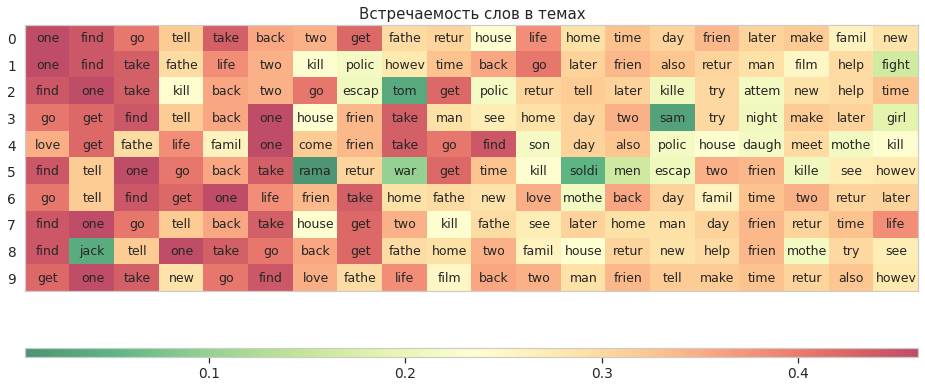

In [30]:
topics = phi_matrix.argsort(1)[:, :-n_top_words-1:-1]
freq_words(topics)

'Красного' существенно больше, чем в предыдущем эксперименте - темы хуже выделяются и очень похожи друг на друга, так как содержат в основном слова общей лексики.


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [31]:
count_vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.1, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

In [32]:
simple_lda = SimpleLDA(n_topics=10,
                       epsilon=1e-15,
                       tol=1e-5)

simple_lda.fit(count_data, verbose_iter=100)


0:
 elbo: -50600711.97381144
 increase: inf

100:
 elbo: -42597432.511439845
 increase: 115.98389542102814

200:
 elbo: -42595804.24231714
 increase: 17.575684241950512

300:
 elbo: -42595652.99805689
 increase: 0.2092747911810875

400:
 elbo: -42595457.04161475
 increase: 6.50063157081604e-05


In [33]:
phi_matrix = simple_lda.phi
print_topics(count_vectorizer, phi_matrix, 20)


Topic #0
john mary play york george peter tom war david henry richard paul couple michael london affair apartment hotel charlie bill

Topic #1
earth ship human team power alien crew battle island monster creature war control use rescue planet mission space agent us

Topic #2
joe jack nick sam john gun gang michael frank mike bill paul apartment drive johnny drug jim prison ben shot

Topic #3
raj singh vijay rahul khan karan kumar wedding movie kapoor amar india hospital village pooja prem college business ajay truth

Topic #4
village raja ravi rao krishna college vijay movie radha ram person hospital kumar king rich arjun wedding rama raju truth

Topic #5
danny jack team game arthur john mike dog war king robert george ship agent play win black mark rescue shot

Topic #6
charlie billy bug gang frank gun tom fire water dog ship harry max sheriff member kid mary red rescue shot

Topic #7
war soldier german captain team ship american army british john crew agent fire gun shot mission gen

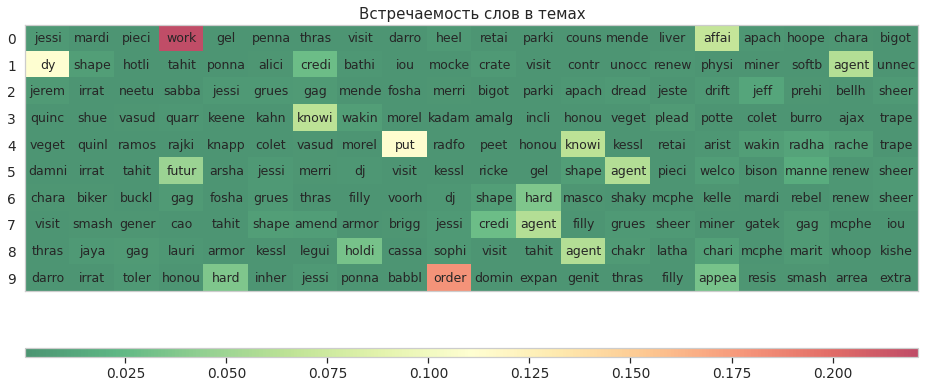

In [34]:
topics = phi_matrix.argsort(1)[:, :-n_top_words-1:-1]
freq_words(topics)

Понятно, что избавившись от большей части общих слов, мы "очищаем" от них и конкретные темы. В результате на "очищенном" датасете алгоритм выдает темы из уникальных слов. Да и слова, составляющие темы связаны друг с другом в достаточной мере. Что-то про индию и свадьбы, что-то про Тома и Джерри, что-то про войну и Германию. Может, они и связаны в основном с одним фильмом, но что-то общее все же в темах есть. 

Ошибка в предыдущем эксперименте была связана с высокой частотностью общих слов. Такие слова встречались часто вне зависимости от темы, а значит, присваивались каждой теме, в которой встречались часто. Иными словами, любая тема считала такие слова своими, так как они в ней встречались часто.

Стандартный LDA все-таки обучается, предполагая, что тема может быть не одна. Так или иначе в каждом документе скорее всего не одна тема, а смесь, ведь это фильмы, а фильмы редко имеют строго одну сюжетную линию. К тому же, предполагая, что в документе смесь тем, мы точнее определим общие слова, ведь мы заведомо признаем их большую вероятность как сумму небольших вероятностей. 